In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

latent_size = 64
hidden_size = 256
image_size = 784

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size),
            nn.Tanh()
        )
        
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)
    

In [14]:
class Generator_2(nn.Module):
    def __init__(self):
        super(Generator_2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator_2(nn.Module):
    def __init__(self):
        super(Discriminator_2, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
generator_v1 = Generator().to(device)
generator_v1.load_state_dict(torch.load('v1/generator.pth'))
generator_v1.eval()

discriminator_v1 = Discriminator().to(device)
discriminator_v1.load_state_dict(torch.load('v1/discriminator.pth'))
discriminator_v1.eval()

generator_v2 = Generator_2().to(device)  # Update to Generator_2 if different
generator_v2.load_state_dict(torch.load('v2/generator.pth'))
generator_v2.eval()

discriminator_v2 = Discriminator_2().to(device)  # Update to Discriminator_2 if different
discriminator_v2.load_state_dict(torch.load('v2/discriminator.pth'))
discriminator_v2.eval()

generator_v3 = Generator_2().to(device)  # Update to Generator_2 if different
generator_v3.load_state_dict(torch.load('v3/generator.pth'))
generator_v3.eval()

discriminator_v3 = Discriminator_2().to(device)  # Update to Discriminator_2 if different
discriminator_v3.load_state_dict(torch.load('v3/discriminator.pth'))
discriminator_v3.eval()

generator_v4 = Generator_2().to(device)  # Update to Generator_2 if different
generator_v4.load_state_dict(torch.load('v4/generator.pth'))
generator_v4.eval()

discriminator_v4 = Discriminator_2().to(device)  # Update to Discriminator_2 if different
discriminator_v4.load_state_dict(torch.load('v4/discriminator.pth'))
discriminator_v4.eval()


Discriminator_2(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Dropout(p=0.1, inplace=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=6272, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [16]:

def calculate_accuracy(generator, discriminator, latent_size=64, batch_size=64, resize=False):
    # Load FashionMNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    total_step = len(test_loader)
    
    total_fake_accuracies = []
    total_real_accuracies = []
    for _ in range(10):
        d_real_accuracies = 0.0
        d_fake_accuracies = 0.0
        with torch.no_grad():
            for _, (images, _) in enumerate(test_loader):
                
                images = images.to(device)

                
                # ================== Evaluate discriminator on real images ================== #
                
                outputs = discriminator(images)
                d_real_accuracy = (outputs > 0.5).float().mean().item()
                
                z = torch.randn(images.size(0), latent_size).to(device)
                fake_images = generator(z)
                fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
                # ================== Evaluate discriminator on fake images ================== #
                outputs = discriminator(fake_images)
                d_fake_accuracy = (outputs < 0.5).float().mean().item()
                
                
                d_real_accuracies += d_real_accuracy
                d_fake_accuracies += d_fake_accuracy
            avg_d_real_accuracy = d_real_accuracies / total_step
            avg_d_fake_accuracy = d_fake_accuracies / total_step
            total_fake_accuracies.append(avg_d_fake_accuracy)
            total_real_accuracies.append(avg_d_real_accuracy)
    
    avg_d_real_accuracy = sum(total_real_accuracies) / len(total_real_accuracies)
    avg_d_fake_accuracy = sum(total_fake_accuracies) / len(total_fake_accuracies)
    print(f'Average Discriminator Real Accuracy: {avg_d_real_accuracy:.4f}')
    print(f'Average Discriminator Fake Accuracy: {avg_d_fake_accuracy:.4f}')
    
    return avg_d_real_accuracy, avg_d_fake_accuracy



In [17]:
calculate_accuracy(generator_v1, discriminator_v2)

Average Discriminator Real Accuracy: 0.7191
Average Discriminator Fake Accuracy: 0.7542


(0.7190684713375797, 0.7541898885350318)

In [18]:
calculate_accuracy(generator_v1, discriminator_v1)

Average Discriminator Real Accuracy: 0.5845
Average Discriminator Fake Accuracy: 0.7973


(0.584514331210191, 0.79734275477707)

In [20]:
calculate_accuracy(generator_v2, discriminator_v2)

Average Discriminator Real Accuracy: 0.7194
Average Discriminator Fake Accuracy: 0.5288


(0.7193670382165605, 0.528781847133758)

In [21]:
calculate_accuracy(generator_v3, discriminator_v3)

Average Discriminator Real Accuracy: 0.8672
Average Discriminator Fake Accuracy: 0.6370


(0.867217356687898, 0.6369824840764331)

In [22]:
calculate_accuracy(generator_v4, discriminator_v4)

Average Discriminator Real Accuracy: 0.8794
Average Discriminator Fake Accuracy: 0.5171


(0.8794187898089172, 0.5171377388535031)

Average Discriminator Real Accuracy: 0.5842
Average Discriminator Fake Accuracy: 0.7943
Average Discriminator Real Accuracy: 0.5841
Average Discriminator Fake Accuracy: 0.6009
Average Discriminator Real Accuracy: 0.5844
Average Discriminator Fake Accuracy: 0.5756
Average Discriminator Real Accuracy: 0.5841
Average Discriminator Fake Accuracy: 0.5977
Average Discriminator Real Accuracy: 0.7197
Average Discriminator Fake Accuracy: 0.7525
Average Discriminator Real Accuracy: 0.7192
Average Discriminator Fake Accuracy: 0.5303
Average Discriminator Real Accuracy: 0.7195
Average Discriminator Fake Accuracy: 0.3598
Average Discriminator Real Accuracy: 0.7195
Average Discriminator Fake Accuracy: 0.3561
Average Discriminator Real Accuracy: 0.8674
Average Discriminator Fake Accuracy: 0.2319
Average Discriminator Real Accuracy: 0.8673
Average Discriminator Fake Accuracy: 0.3567
Average Discriminator Real Accuracy: 0.8675
Average Discriminator Fake Accuracy: 0.6373
Average Discriminator Real Accur

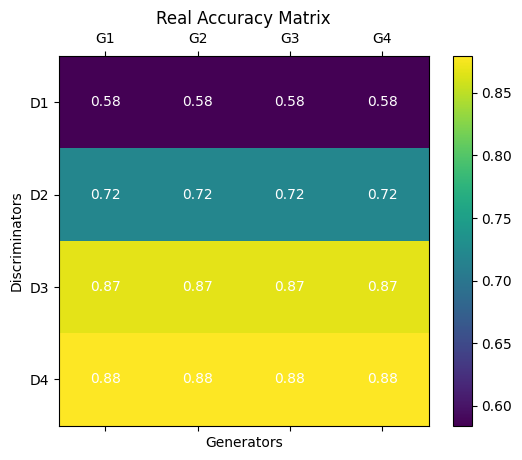

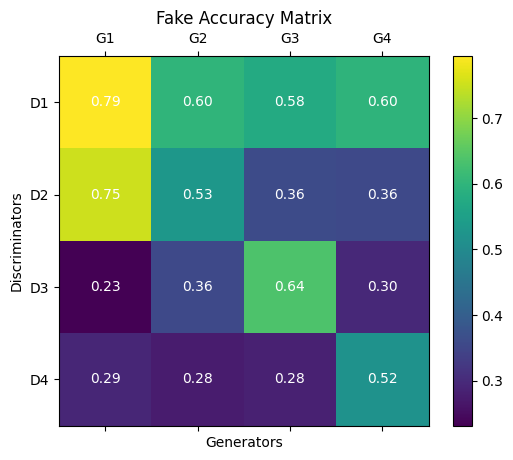

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_accuracy_matrix(generators, discriminators, latent_size=64, batch_size=64):
    real_accuracy_matrix = np.zeros((len(discriminators), len(generators)))
    fake_accuracy_matrix = np.zeros((len(discriminators), len(generators)))
    
    for d_idx, discriminator in enumerate(discriminators):
        for g_idx, generator in enumerate(generators):
            avg_d_real_accuracy, avg_d_fake_accuracy = calculate_accuracy(generator, discriminator, latent_size, batch_size)
            real_accuracy_matrix[d_idx, g_idx] = avg_d_real_accuracy
            fake_accuracy_matrix[d_idx, g_idx] = avg_d_fake_accuracy
    
    return real_accuracy_matrix, fake_accuracy_matrix

def plot_accuracy_matrix(matrix, title, generators, discriminators):
    fig, ax = plt.subplots()
    cax = ax.matshow(matrix, cmap='viridis')
    fig.colorbar(cax)

    for i in range(len(discriminators)):
        for j in range(len(generators)):
            ax.text(j, i, f'{matrix[i, j]:.2f}', va='center', ha='center', color='white')
        
    ax.set_xticks(np.arange(len(generators)))
    ax.set_yticks(np.arange(len(discriminators)))
    ax.set_xticklabels([f'G{i+1}' for i in range(len(generators))])
    ax.set_yticklabels([f'D{i+1}' for i in range(len(discriminators))])
    plt.xlabel('Generators')
    plt.ylabel('Discriminators')
    plt.title(title)
    plt.show()

# Example usage
generators = [generator_v1,generator_v2, generator_v3, generator_v4]
discriminators = [discriminator_v1, discriminator_v2, discriminator_v3, discriminator_v4]

real_accuracy_matrix, fake_accuracy_matrix = calculate_accuracy_matrix(generators, discriminators)
plot_accuracy_matrix(real_accuracy_matrix, "Real Accuracy Matrix", generators, discriminators)
plot_accuracy_matrix(fake_accuracy_matrix, "Fake Accuracy Matrix", generators, discriminators)


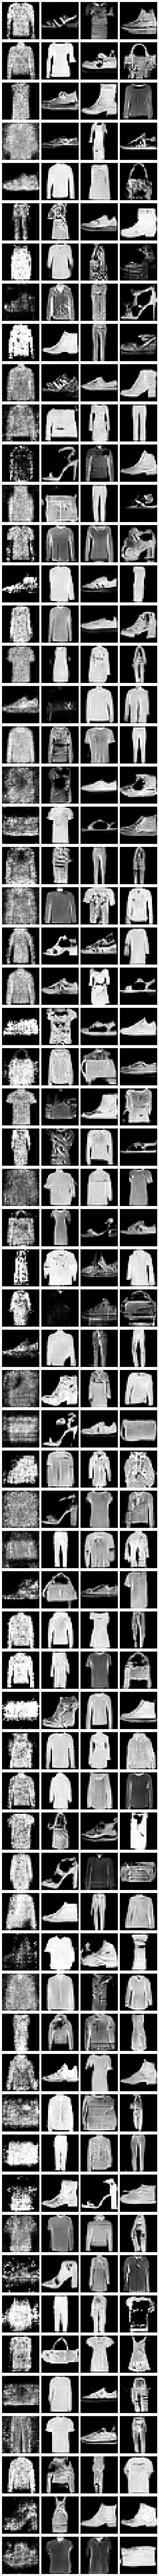

In [24]:
import matplotlib.pyplot as plt

def display_fixed_generated_images(generators, latent_size=64, num_images=64):
    # Create a fixed latent vector for generating images
    fixed_z = torch.randn(num_images, latent_size).to(device)
    
    # Initialize a figure for plotting
    _, axes = plt.subplots(num_images, len(generators), figsize=(len(generators)*2, num_images*2))
    
    for i in range(num_images):
        for j, generator in enumerate(generators):
            # Generate an image using the current generator with the fixed latent vector
            generator.eval()
            with torch.no_grad():
                generated_image = generator(fixed_z[i].unsqueeze(0)).view(28, 28).cpu().numpy()
            
            # Display the generated image in the appropriate subplot
            ax = axes[i, j]
            ax.imshow(generated_image, cmap='gray')
            ax.axis('off')
    
    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

# Example usage
generators = [generator_v1, generator_v2, generator_v3, generator_v4]
display_fixed_generated_images(generators)
